# 1. 영상 인식

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import datasets,transforms,utils
from torch.autograd import Variable 
import matplotlib.pyplot as plt 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


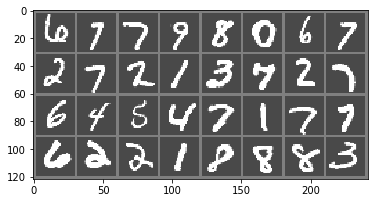

In [ ]:
%matplotlib inline 

# gpu 사용 체크
is_cuda=False 
if torch.cuda.is_available(): 
  is_cuda = True 

# 텐서로 변환, normalize
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]) 

# MNIST dataset
train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True) 
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True) 

# loader는 iterator 반환
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True) #shuffle : 랜덤으로 섞기
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True) 

sample_images, sample_data = next(iter(train_loader))
imshow(utils.make_grid(sample_images))

# 이미지 출력
def plot_img(image): 
  image = image.numpy()[0] 
  mean = 0.1307
  std = 0.3081
  image = ((mean * image) + std) 
  plt.imshow(image,cmap='gray') 

(1) 화면 출력 확인

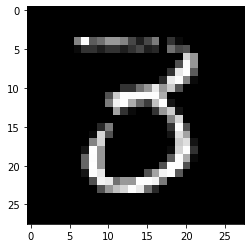

In [ ]:
plot_img(sample_data[0][2]) 

(2) 화면 출력 확인

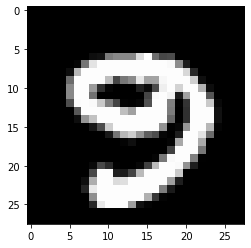

In [ ]:
plot_img(sample_data[0][1]) 

In [ ]:
class Net(nn.Module): 
  # 모듈 정의
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # input: 1, output: 10
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
    # fully connect에서 연결을 랜덤으로 drop
    self.conv2_drop = nn.Dropout2d()
    # input, output. 선형 함수를 사용하여 입력으로 부터 출력 계산
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10) 

  def forward(self, x): 
    # max pooling over a (2,2) window
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
    # if the size is a square you can only specify a single number
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) 
    # -1은 다른 차원으로부터 추론된다
    x = x.view(-1, 320) 
    x = F.relu(self.fc1(x)) 
    #x = F.dropout(x,p=0.1, training=self.training) 
    x = self.fc2(x) 

    # softmax로 확률 값으로 반환
    return F.log_softmax(x,dim=1) 

model = Net() 
if is_cuda: 
  model.cuda()

# Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), 0.01) 

# 훈련집합에서 data랑 target 가져오기
data , target = next(iter(train_loader)) 

# gpu에 data 올리기
output = model(Variable(data.cuda())) 

(3) output.size() 출력 확인

In [ ]:
print("output.size():", output.size())

output.size(): torch.Size([32, 10])


(4) target.size() 출력 확인

In [ ]:
print("target.size():", target.size())

target.size(): torch.Size([32])


(5) 화면 출력 확인

In [ ]:
def fit(epoch, model, data_loader, phase='training', volatile=False): 
  if phase == 'training': 
    model.train() 
  if phase == 'validation': 
    model.eval() 
    volatile=True 
  # 초기값
  running_loss = 0.0 
  running_correct = 0 

  for batch_idx , (data,target) in enumerate(data_loader): 
    if is_cuda: 
      data,target = data.cuda(),target.cuda()
    #volatile = false면 역전파 사용을 위해 메모리에 올림 
    data , target = Variable(data,volatile), Variable(target) 

    if phase == 'training': 
      # 변화도 0으로
      optimizer.zero_grad() 

    # 학습  
    output = model(data) 
    # negative log likelihood
    loss = F.nll_loss(output,target) 

    running_loss += F.nll_loss(output,target,size_average=False).data
    preds = output.data.max(dim=1, keepdim=True)[1] #예측값
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 

    if phase == 'training': 
      # 역전파
      loss.backward() 
      # 가중치 갱신
      optimizer.step() 

  # loss 평균
  loss = running_loss/len(data_loader.dataset) 
  accuracy = 100. * running_correct/len(data_loader.dataset) 

  print(f"{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}") 
  return loss, accuracy 

train_losses, train_accuracy = [], [] 
val_losses, val_accuracy = [], [] 

# 20번 학습
for epoch in range(1,20): 
  epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training') 
  val_epoch_loss, val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation') 
  train_losses.append(epoch_loss) 
  train_accuracy.append(epoch_accuracy) 
  val_losses.append(val_epoch_loss) 
  val_accuracy.append(val_epoch_accuracy) 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.61 and training accuracy is 48682/60000     81.14
validation loss is  0.15 and validation accuracy is 9568/10000     95.68
training loss is   0.2 and training accuracy is 56579/60000      94.3
validation loss is 0.087 and validation accuracy is 9735/10000     97.35
training loss is  0.15 and training accuracy is 57316/60000     95.53
validation loss is  0.07 and validation accuracy is 9777/10000     97.77
training loss is  0.13 and training accuracy is 57668/60000     96.11
validation loss is 0.062 and validation accuracy is 9802/10000     98.02
training loss is  0.12 and training accuracy is 57961/60000      96.6
validation loss is 0.053 and validation accuracy is 9830/10000      98.3
training loss is   0.1 and training accuracy is 58120/60000     96.87
validation loss is 0.048 and validation accuracy is 9841/10000     98.41
training loss is 0.097 and training accuracy is 58262/60000      97.1
validation loss is 0.049 and validation accuracy is 9837/10000     98.37

(6) 화면 출력 확인

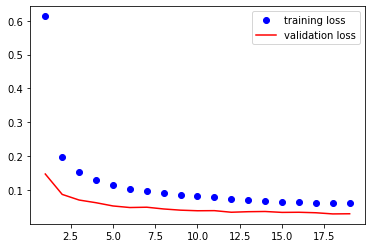

In [ ]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss') 
plt.plot(range(1,len(val_losses)+1),val_losses,'r', label = 'validation loss') 
plt.legend() 

(7) 화면 출력 확인

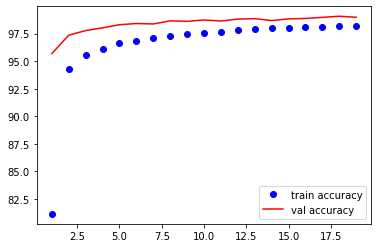

In [ ]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy,'bo', label = 'train accuracy') 
plt.plot(range(1, len(val_accuracy)+1),val_accuracy,'r', label = 'val accuracy') 
plt.legend() 

# 2. CNN

In [ ]:
# torch.nn 패키지를 사용하여 신경망을 생성함. 
# nn 패키지는 모델을 정의할 때, autograd를 통해 자동미분 기능을 제공함 
# nn.Module은 층과 전방전파forward propagation (입력 출력)을 쉽게 구현함 
# 참고로 m패키지는 minibatch만 지원함, 예로 nCon2d는 4차 Tensor를 받음 (Samples nChanes *height *width) 
# 아래 AlexNet (이미 수업에서 학습함) 예시는 숫자를 분류하는 간단한 컨볼루션 신경망의 예임 

# 예시는 사진 입력을 받고, 몇 개의 층에 전방 전파하면서 분류를 출력함 
# 출력을 위해서 모델은 다음과 같은 학습을 수행함 
# - 신경망은 학습가능한 매개변수들 (가중치들)을 가짐 
# - 사진 데이터를 반복적으로 입력함 
# - 신경망을 통해 입력을 처리함 (전방 전파) 
# - 손실 (오차)를 계산함 (실제 출력과 예측 출력을 비교하여 학습의 올바름을 판단함) 
# - 오차로부터 그레이디언트 (경사, 방향)을 신경망의 각 매개 변수에게 역전파함 (오류 역전파) 
# - 신경망의 매개 변수들을 갱신함 ( (미래)가중치 = (현재)가중치 - 학습률 * 그레이디언트)  

# 위의 컨볼루션 신경망의 부분들을 torch를 통해서 손쉽게 구현할 수 있음 
# 단지 forwad함수만정의하면 atogad를 이용해해당 연산그래프의 그레이디언트를 구하는 badwad 자동적으로 정의됨 
# forward 함수는 Tensor를 이용할 수 있는 다양한 연산들 (합, 곱 등등) 사용하여 정의 가능함 
# torch.Tensor: 자동 미분 기능을 지원하는 다차원 배열, 각 Tensor에 해당하는 그레이디언트를 가짐 
# nn.Module: 신경망 모듈이며 매개변수의 캡슐화, GPU 연산 등 작업을 쉽게 가능하게 함 
# nn.Parameter: 모듈이 지정되면 매개변수들을 자동으로 관리하는 Tensor의 하나임 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn.Module): 
  def __init__(self): 
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels, 5x5 kernel
    self.conv1 = nn.Conv2d(1, 6, 5) 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # input(vector), output(vector)
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
  
  def forward(self, x): 
    # Max pooling over a (2, 2) window 
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
    # If the size is a square you can only specify a single number 
    x = F.max_pool2d(F.relu(self.conv2(x)), 2) 

    # x.view(-1, size) : tensor -> vector
    x = x.view(-1, self.num_flat_features(x)) 
    # fully connect (input, output)
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 
    return x 

  # num_flat_features : x(tensor) 크기 반환
  def num_flat_features(self, x): 
    size = x.size()[1:] # all dimensions except the batch dimension 
    num_features = 1 
    for s in size: 
      num_features *= s 
    return num_features 

net = Net() 

(1) 화면 출력 확인 및 의미를 서술

In [ ]:
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


conv : 컨볼루션 층 
(input 채널, output 채널, 커널 사이즈, 보폭)

fc : fully connect 연산
(인풋(vector) 크기, output(vecotr) 크기)
             
            
-2개의 컨볼루션 층과 3개의 fc로 이루어진 신경망
    

(2) 정의된 컨볼루션 신경망의 구조 설명 (위의 AlexNet 그림 참고)

컨볼루션 층 2개와 완전 연결층 3개

conv1 -> relu -> max_pool2d(2,2) : 반으로 축소(sampling) 
-> conv2 -> relu -> max_pool2d(sampling) 
-> view (tensor -> vector로) -> full connection(feature의 개수를 줄여줌) -> full connection -> full connection

(3) 화면 출력 확인

In [ ]:
# net.parameters()를 사용하여 정의된 신경망의 학습가능한 매개변수들을 확인할 수 있음 
params = list(net.parameters()) 
print(len(params)) 
print(params[0].size()) # conv1's .weight 

10
torch.Size([6, 1, 5, 5])


(4) 화면 출력 확인

In [ ]:
# 다음의 임의의 32*32 입력을 가정함 
# 참고로 크기가 다른 입력을 받을 때는 입력의 크기를 재조정하거나 신경망 수정함 
input = torch.randn(1, 1, 32, 32) 
out = net(input) 
print(out)

tensor([[-0.0788, -0.0600,  0.0901, -0.0048,  0.0371,  0.0151,  0.0129,  0.0290,
          0.0015, -0.0840]], grad_fn=<AddmmBackward>)


In [ ]:
# 오류역전파를 통해 그레이디언트를 구하기 전에 모든 가중치의 그레이디언트 버퍼들을 초기화 
net.zero_grad() 
out.backward(torch.randn(1, 10)) 

# 손실 함수 정의 및 임의의 값들에 대해서 오차 결과 확인 
# nn 패키지는 많이 사용되는 손실함수들을 제공하며, 해당 예제는 단순한 MSE를 사용 
output = net(input) 
target = torch.randn(10) # a dummy target, for example 
target = target.view(1, -1) # make it the same shape as output 
criterion = nn.MSELoss() # 손실함수

loss = criterion(output, target) 

(5) 화면 출력 확인 

In [ ]:
print(loss) 

tensor(0.9270, grad_fn=<MseLossBackward>)


(6) 화면 출력 확인

In [ ]:
# 앞에 코드에서 언급한 것과 같이 오류 역전파하기 전, 그레이디언트를 초기화해야 함 
# backward() 수행 후 어떤 변화가 있는지 확인하고, 초기화의 필요성을 확인함 
net.zero_grad() #zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward') 
print(net.conv1.bias.grad) # backward() 전

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


(7) 화면 출력 확인

In [ ]:
loss.backward() 

print('conv1.bias.grad after backward') 
print(net.conv1.bias.grad) # backward() 후

conv1.bias.grad after backward
tensor([ 0.0022,  0.0010,  0.0029,  0.0054, -0.0045,  0.0080])


In [ ]:
# 스토캐스틱경사하강법 (미라가중치= 현재가중치-학습률*그레이디언트)을 이용하여 가중치 갱신하는 코드
learning_rate = 0.01 

#가중치 갱신
for f in net.parameters(): 
  f.data.sub_(f.grad.data * learning_rate) 

# 하지만 위 구현 코드보다 실제, torch.optim에서 구현되는 SDG, Adam, RMSProp 등을 사용함 
# 오류 역전파에서 최적화하는 방법을 보인 예제 코드 
import torch.optim as optim 

# create your optimizer / Stochastic Gradient Descent
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop: 
optimizer.zero_grad() # zero the gradient buffers 
output = net(input) 
loss = criterion(output, target) 
loss.backward() 
optimizer.step() # Does the update (가중치 갱신)
print(loss)

tensor(0.9146, grad_fn=<MseLossBackward>)


# 3. 분류기 학습

(1) 화면 출력 확인

In [ ]:
# 1번의 기초적인 신경망을 통해서 사진 분류기를 학습함 
# 데이터집합은 CIFAR-10이며, 아래의 예와 같이 10가지의 3 (R, G, B)채널의 32*32 크기의 사진으로 구성됨 

# CIFAR-10과 같이 많이 사용되는 데이터집합은 torchvision 패키지에서 제공함 
# 분류기 학습은 다음과 같은 과정을 가짐 
# 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함 
# 2. 컨볼루션 신경망을 정의함 
# 3. 손실함수 정의 
# 4. 훈련집합을 이용하여 신경망을 학습시킴 
# 5. 테스트집합을 이용하여 신경망 성능 확인 
 
### 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함 
import torch 
import torchvision 
import torchvision.transforms as transforms 

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.CIFAR10(root='/data', train=True, download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) 

testset = torchvision.datasets.CIFAR10(root='/data', train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2) 

# 분류 10개 class
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 


Files already downloaded and verified
Files already downloaded and verified


(2) 화면 출력 확인

horse truck plane  ship


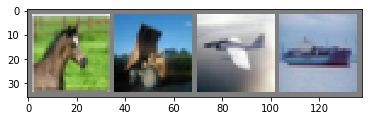

In [ ]:
# 훈련집합의 일부 사진들 확인 
import matplotlib.pyplot as plt 
import numpy as np 

# functions to show an image 
def imshow(img): 
  img = img / 2 + 0.5   # unnormalize 
  npimg = img.numpy() 
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 

# get some random training images 
dataiter = iter(trainloader) 
images, labels = dataiter.next() 

# show images 
imshow(torchvision.utils.make_grid(images)) 
# print labels 
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 

(3) 화면 출력 확인 및 학습이 되고 있는지 서술 

In [ ]:
### 2. 컨볼류션 신경망을 정의함 
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10부류를 수행 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn. Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    # conv2d(input, output, kernel size)
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # linear(input size, output size)
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
  
  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x))) 
    # tensor -> vector
    x = x.view(-1, 16 * 5 * 5) 
    # full connection
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 
    return x 

net = Net() 

### 3. 손실함수 정의, 교차 엔트로이피와 SGD+momentum 
import torch.optim as optim 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times 

  running_loss = 0.0 
  # 훈련집합 반복
  for i, data in enumerate(trainloader, 0): 
    # get the inputs (tensor, label)
    inputs, labels = data 
    
    # zero the parameter gradients 
    optimizer.zero_grad() 

    # forward + backward + optimize 
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    loss.backward() 
    optimizer.step() # 가중치 갱신
  
    # print statistics 
    running_loss += loss.item() # 총합
    if i % 1000 == 999:   # print every 1000 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000)) 
      running_loss = 0.0 
print('Finished Training')

[1,  1000] loss: 2.296
[1,  2000] loss: 2.105
[1,  3000] loss: 1.917
[1,  4000] loss: 1.828
[1,  5000] loss: 1.744
[1,  6000] loss: 1.657
[1,  7000] loss: 1.624
[1,  8000] loss: 1.595
[1,  9000] loss: 1.557
[1, 10000] loss: 1.503
[1, 11000] loss: 1.483
[1, 12000] loss: 1.460
[2,  1000] loss: 1.397
[2,  2000] loss: 1.371
[2,  3000] loss: 1.367
[2,  4000] loss: 1.379
[2,  5000] loss: 1.358
[2,  6000] loss: 1.329
[2,  7000] loss: 1.307
[2,  8000] loss: 1.325
[2,  9000] loss: 1.280
[2, 10000] loss: 1.276
[2, 11000] loss: 1.288
[2, 12000] loss: 1.275
Finished Training


1000번 마다 1000개의 평균으로 epoch, 횟수, loss를 출력하고 있다.    
데이터가 학습되면서 loss가 줄어들고 있다.
학습이 되고있다.

(4) 화면 출력 확인

GroundTruth:   cat  ship  ship plane


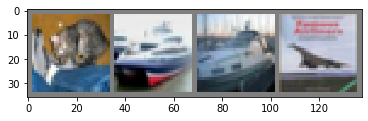

In [ ]:
### 5. 테스트집합을 이용하여 신경망 성능 확인
dataiter = iter(testloader) 
images, labels = dataiter.next() 

# print images 
imshow(torchvision.utils.make_grid(images)) 
print('GroundTruth:',' '.join('%5s' % classes[labels[j]] for j in range(4)))

(5) 화면 출력 확인

In [ ]:
outputs = net(images) 
# max index를 predicted에
_, predicted = torch.max(outputs, 1) 
# 가장 큰 예측 결과값 출력
print('Predicted:',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   cat  ship truck  ship


(6) 화면 출력 확인 및 일반화 성능 기술

In [ ]:
# performance on the whole test dataset 
correct = 0 
total = 0 

# 역연산 X
with torch.no_grad():
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) #총갯수
    correct += (predicted == labels).sum().item() #맞는 것만

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 55 %


10000개 test image의 정확도는 55%

(7) 화면 출력 확인 및 부류별 분류기의 성능 서술

In [ ]:
 # performance on each class 
 class_correct = list(0. for i in range(10)) 
 class_total = list(0. for i in range(10)) 

with torch.no_grad(): 
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4): 
      label = labels[i] #정답값 label
      class_correct[label] += c[i].item() #맞았으면 +1
      class_total[label] += 1 

for i in range(10): 
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 75 %
Accuracy of  bird : 42 %
Accuracy of   cat : 33 %
Accuracy of  deer : 41 %
Accuracy of   dog : 26 %
Accuracy of  frog : 73 %
Accuracy of horse : 62 %
Accuracy of  ship : 60 %
Accuracy of truck : 65 %


10개의 분류별 정확도를 확인할 수 있음.    
car가 75%로 가장 높고 dog이 26%로 가장 낮은 정확률을 가지고 있다.    

# 4. 출력의 크기와 매개변수의 수 계산

입력 : 32 * 32 * 3 (W1 * H1 * D1)      
    
(a) 10개 5 * 5필터, 보폭 1, 덧대기 2    
     K개 F * F필터, 보폭 S, 덧대기 P
    
출력의 크기: W2 * H2 * D2    
W2 = (W1 - F + 2P)/S+1 = 32    
H2 = (H1 - F + 2P)/S+1 = 32    
D2 = K = 10    
-> 32 * 32 * 10 = 10240    
    
매개변수의 수: 커널마다 (5 * 5 * 3)개의 가중치와 1개의 바이어스를 가짐    
따라서, 전체 매개변수의 수는 (5 * 5 * 3)10+10 = 760
    
    

(b) 64개 3*3필터, 보폭 1, 덧대기 1
    
출력의 크기:    
W2 = (32 - 3 + 2 * 1)/1+1 = 32    
H2 = (32 - 3 + 2 * 1)/1+1 = 32   
D2 = 64    
-> 32 * 32 * 64 = 65536    
    
매개변수의 수:    
(3 * 3 * 3) * 64 + 64 = 1792    



# 5. 컨볼루션 신경망 구현

(1) input-conv(32 3*3)-conv(32 3*3)-relu-pool-conv(32 3*3)-conv(32 3*3)-relu-pool-fc-output

In [ ]:
### 2. 컨볼류션 신경망을 정의함 
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10부류를 수행 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn. Module): 
  def __init__(self): 
    super(Net, self).__init__() 

    # 합성곱층
    # Conv2d(입력채널, 출력채널, 커널 사이즈)
    self.conv1 = nn.Conv2d(3, 32, 3) 
    self.conv2 = nn.Conv2d(32, 32, 3) 
    # 가로세로 반으로 축소
    self.pool = nn.MaxPool2d(2, 2) 
    # 전결합층
    # Linear(인풋(벡터)사이즈, 아웃풋(벡터)사이즈)
    self.fc = nn.Linear(5 * 5*32, 10) 
  
  def forward(self, x): 
    # conv - conv - relu - pool - conv - conv - relu - pool - fc
    x = self.conv1(x)                     #32*32*3
    x = self.pool(F.relu(self.conv2(x)))  #30*30*32 -> 28*28*32 -> 14*14*32

    x = self.conv2(x)                     #14*14*32
    x = self.pool(F.relu(self.conv2(x)))  #12*12*32 -> 10*10*32 -> 5*5*32

    # tensor -> vector
    x = x.view(-1, 5 * 5*32)  
    x = self.fc(x) 
    return x 

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=800, out_features=10, bias=True)
)


(2) 3번 신경망에 Adam 최적화

In [ ]:
##### 원래 3번 신경망 #####
### 2. 컨볼류션 신경망을 정의함 
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10부류를 수행 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn. Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
  
  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x))) 
    x = x.view(-1, 16 * 5 * 5) 
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 
    return x 

net = Net() 


In [ ]:
### 3. 손실함수 정의, 교차 엔트로이피와 SGD+momentum 
import torch.optim as optim 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times 

  running_loss = 0.0 
  for i, data in enumerate(trainloader, 0): 
    # get the inputs 
    inputs, labels = data 
    
    # zero the parameter gradients 
    optimizer.zero_grad() 

    # forward + backward + optimize 
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    loss.backward() 
    optimizer.step() 
  
    # print statistics 
    running_loss += loss.item() 
    if i % 1000 == 999:   # print every 1000 mini-batches 
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000)) 
      running_loss = 0.0 
print('Finished Training')

[1,  1000] loss: 2.302
[1,  2000] loss: 2.199
[1,  3000] loss: 2.012
[1,  4000] loss: 1.885
[1,  5000] loss: 1.825
[1,  6000] loss: 1.769
[1,  7000] loss: 1.714
[1,  8000] loss: 1.666
[1,  9000] loss: 1.633
[1, 10000] loss: 1.637
[1, 11000] loss: 1.622
[1, 12000] loss: 1.593
[2,  1000] loss: 1.571
[2,  2000] loss: 1.572
[2,  3000] loss: 1.535
[2,  4000] loss: 1.506
[2,  5000] loss: 1.504
[2,  6000] loss: 1.455
[2,  7000] loss: 1.481
[2,  8000] loss: 1.481
[2,  9000] loss: 1.484
[2, 10000] loss: 1.451
[2, 11000] loss: 1.447
[2, 12000] loss: 1.422
Finished Training


In [ ]:
# performance on the whole test dataset 
correct = 0 
total = 0 
with torch.no_grad():
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 48 %


In [ ]:
 # performance on each class 
 class_correct = list(0. for i in range(10)) 
 class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4): 
      label = labels[i] 
      class_correct[label] += c[i].item() 
      class_total[label] += 1 

for i in range(10): 
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 61 %
Accuracy of  bird : 20 %
Accuracy of   cat : 41 %
Accuracy of  deer : 50 %
Accuracy of   dog : 40 %
Accuracy of  frog : 56 %
Accuracy of horse : 35 %
Accuracy of  ship : 69 %
Accuracy of truck : 57 %


In [ ]:
##### 수정한 3번 신경망 #####
### 3. 손실함수 정의, 교차 엔트로이피와 Adam
import torch.optim as optim 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr=1e-3) 

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times 

  running_loss = 0.0 
  for i, data in enumerate(trainloader, 0): 
    # get the inputs 
    inputs, labels = data 
    
    # zero the parameter gradients 
    optimizer.zero_grad() 

    # forward + backward + optimize 
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    loss.backward() 
    optimizer.step() 
  
    # print statistics 
    running_loss += loss.item() 
    if i % 1000 == 999:   # print every 1000 mini-batches 
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000)) 
      running_loss = 0.0 
print('Finished Training')

[1,  1000] loss: 1.496
[1,  2000] loss: 1.489
[1,  3000] loss: 1.450
[1,  4000] loss: 1.440
[1,  5000] loss: 1.436
[1,  6000] loss: 1.444
[1,  7000] loss: 1.457
[1,  8000] loss: 1.412
[1,  9000] loss: 1.424
[1, 10000] loss: 1.395
[1, 11000] loss: 1.418
[1, 12000] loss: 1.422
[2,  1000] loss: 1.373
[2,  2000] loss: 1.376
[2,  3000] loss: 1.370
[2,  4000] loss: 1.365
[2,  5000] loss: 1.361
[2,  6000] loss: 1.374
[2,  7000] loss: 1.367
[2,  8000] loss: 1.331
[2,  9000] loss: 1.348
[2, 10000] loss: 1.376
[2, 11000] loss: 1.358
[2, 12000] loss: 1.328
Finished Training


In [ ]:
# performance on the whole test dataset 
correct = 0 
total = 0 
with torch.no_grad():
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 61 %


In [ ]:
 # performance on each class 
 class_correct = list(0. for i in range(10)) 
 class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4): 
      label = labels[i] 
      class_correct[label] += c[i].item() 
      class_total[label] += 1 

for i in range(10): 
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 83 %
Accuracy of  bird : 47 %
Accuracy of   cat : 43 %
Accuracy of  deer : 47 %
Accuracy of   dog : 59 %
Accuracy of  frog : 63 %
Accuracy of horse : 60 %
Accuracy of  ship : 79 %
Accuracy of truck : 65 %


원래 SGD를 사용한 신경망의 정확도는 48%, Adam을 사용한 신경망의 정확도는 61%로 Adam을 사용한 신경망의 정확도가 더 높게 나왔다.    
그 밖에도 각 class별 정확도나 loss값을 보면 Adam의 성능이 더 좋은 걸 알 수 있다.    

(3) 데이터 확대

In [ ]:
# 이미지 변형을 통해 데이터를 확대시킴
transform = transforms.Compose([transforms.RandomRotation(10),                                        #10도 이하로 랜덤으로 기울임
                                transforms.RandomHorizontalFlip(),                                    # 0.5 확률로 뒤집음
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),               #Affine 변환
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #밝기,대비,채도를 랜덤 조절
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

Files already downloaded and verified
Files already downloaded and verified
  cat   dog horse  deer


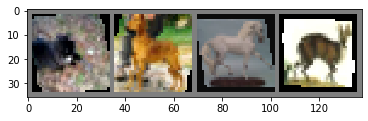

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data', train=True, download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) 

testset = torchvision.datasets.CIFAR10(root='/data', train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2) 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

# 훈련집합의 일부 사진들 확인 
import matplotlib.pyplot as plt 
import numpy as np 

# functions to show an image 
def imshow(img): 
  img = img / 2 + 0.5   # unnormalize 
  npimg = img.numpy() 
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 

# get some random training images 
dataiter = iter(trainloader) 
images, labels = dataiter.next() 

# show images 
imshow(torchvision.utils.make_grid(images)) 
# print labels 
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 

In [ ]:
##### 원래 3번 신경망 #####
### 2. 컨볼류션 신경망을 정의함 
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10부류를 수행 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn. Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
  
  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x))) 
    x = x.view(-1, 16 * 5 * 5) 
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 
    return x 

net = Net() 


In [ ]:
### 3. 손실함수 정의, 교차 엔트로이피와 SGD+momentum 
import torch.optim as optim 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times 

  running_loss = 0.0 
  for i, data in enumerate(trainloader, 0): 
    # get the inputs 
    inputs, labels = data 
    
    # zero the parameter gradients 
    optimizer.zero_grad() 

    # forward + backward + optimize 
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    loss.backward() 
    optimizer.step() 
  
    # print statistics 
    running_loss += loss.item() 
    if i % 1000 == 999:   # print every 1000 mini-batches 
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000)) 
      running_loss = 0.0 
print('Finished Training')

[1,  1000] loss: 2.301
[1,  2000] loss: 2.237
[1,  3000] loss: 2.009
[1,  4000] loss: 1.875
[1,  5000] loss: 1.809
[1,  6000] loss: 1.752
[1,  7000] loss: 1.710
[1,  8000] loss: 1.679
[1,  9000] loss: 1.625
[1, 10000] loss: 1.629
[1, 11000] loss: 1.599
[1, 12000] loss: 1.578
[2,  1000] loss: 1.543
[2,  2000] loss: 1.542
[2,  3000] loss: 1.522
[2,  4000] loss: 1.489
[2,  5000] loss: 1.508
[2,  6000] loss: 1.479
[2,  7000] loss: 1.484
[2,  8000] loss: 1.463
[2,  9000] loss: 1.464
[2, 10000] loss: 1.430
[2, 11000] loss: 1.421
[2, 12000] loss: 1.464
Finished Training


In [ ]:
# performance on the whole test dataset 
correct = 0 
total = 0 
with torch.no_grad():
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 50 %


In [ ]:
 # performance on each class 
 class_correct = list(0. for i in range(10)) 
 class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4): 
      label = labels[i] 
      class_correct[label] += c[i].item() 
      class_total[label] += 1 

for i in range(10): 
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 53 %
Accuracy of  bird : 49 %
Accuracy of   cat : 31 %
Accuracy of  deer : 40 %
Accuracy of   dog : 39 %
Accuracy of  frog : 59 %
Accuracy of horse : 56 %
Accuracy of  ship : 58 %
Accuracy of truck : 57 %


(4) 3번 신경망에 conv 층마다 배치 정규화

In [ ]:
### 2. 컨볼류션 신경망을 정의함 
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10부류를 수행 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn. Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.conv2 = nn.Conv2d(6, 16, 5) 

    # 배치 정규화
    self.bn1 = nn.BatchNorm2d(6)
    self.bn2 = nn.BatchNorm2d(16)

    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
  
  def forward(self, x): 
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) 
    x = self.pool(F.relu(self.bn2(self.conv2(x)))) 
    x = x.view(-1, 16 * 5 * 5) 
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 
    return x 

net = Net() 

### 3. 손실함수 정의, 교차 엔트로이피와 SGD+momentum 
import torch.optim as optim 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times 

  running_loss = 0.0 
  for i, data in enumerate(trainloader, 0): 
    # get the inputs 
    inputs, labels = data 
    
    # zero the parameter gradients 
    optimizer.zero_grad() 

    # forward + backward + optimize 
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    loss.backward() 
    optimizer.step() 
  
    # print statistics 
    running_loss += loss.item() 
    if i % 1000 == 999:   # print every 1000 mini-batches 
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000)) 
      running_loss = 0.0 
print('Finished Training')

[1,  1000] loss: 2.086
[1,  2000] loss: 1.831
[1,  3000] loss: 1.742
[1,  4000] loss: 1.707
[1,  5000] loss: 1.608
[1,  6000] loss: 1.611
[1,  7000] loss: 1.571
[1,  8000] loss: 1.552
[1,  9000] loss: 1.517
[1, 10000] loss: 1.515
[1, 11000] loss: 1.483
[1, 12000] loss: 1.433
[2,  1000] loss: 1.400
[2,  2000] loss: 1.394
[2,  3000] loss: 1.380
[2,  4000] loss: 1.384
[2,  5000] loss: 1.358
[2,  6000] loss: 1.373
[2,  7000] loss: 1.342
[2,  8000] loss: 1.348
[2,  9000] loss: 1.329
[2, 10000] loss: 1.309
[2, 11000] loss: 1.301
[2, 12000] loss: 1.307
Finished Training


In [ ]:
# performance on the whole test dataset 
correct = 0 
total = 0 
with torch.no_grad():
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
 # performance on each class 
 class_correct = list(0. for i in range(10)) 
 class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4): 
      label = labels[i] 
      class_correct[label] += c[i].item() 
      class_total[label] += 1 

for i in range(10): 
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 59 %
Accuracy of  bird : 24 %
Accuracy of   cat : 24 %
Accuracy of  deer : 41 %
Accuracy of   dog : 49 %
Accuracy of  frog : 80 %
Accuracy of horse : 62 %
Accuracy of  ship : 61 %
Accuracy of truck : 70 %


(5) 3번 신경망에 로그우도

In [ ]:
### 2. 컨볼류션 신경망을 정의함 
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10부류를 수행 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn. Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
  
  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x))) 
    x = x.view(-1, 16 * 5 * 5) 
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 

    # output에 softmax
    return F.log_softmax(x)

net = Net() 

### 3. 손실함수 정의, 로그우도와 SGD+momentum 
import torch.optim as optim 

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times 

  running_loss = 0.0 
  for i, data in enumerate(trainloader, 0): 
    # get the inputs 
    inputs, labels = data 
    
    # zero the parameter gradients 
    optimizer.zero_grad() 

    # forward + backward + optimize 
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    loss.backward() 
    optimizer.step() 
  
    # print statistics 
    running_loss += loss.item() 
    if i % 1000 == 999:   # print every 1000 mini-batches 
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000)) 
      running_loss = 0.0 
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  1000] loss: 2.296
[1,  2000] loss: 2.107
[1,  3000] loss: 1.964
[1,  4000] loss: 1.862
[1,  5000] loss: 1.787
[1,  6000] loss: 1.705
[1,  7000] loss: 1.667
[1,  8000] loss: 1.597
[1,  9000] loss: 1.552
[1, 10000] loss: 1.518
[1, 11000] loss: 1.487
[1, 12000] loss: 1.492
[2,  1000] loss: 1.421
[2,  2000] loss: 1.398
[2,  3000] loss: 1.411
[2,  4000] loss: 1.409
[2,  5000] loss: 1.380
[2,  6000] loss: 1.362
[2,  7000] loss: 1.327
[2,  8000] loss: 1.333
[2,  9000] loss: 1.291
[2, 10000] loss: 1.285
[2, 11000] loss: 1.297
[2, 12000] loss: 1.294
Finished Training


In [ ]:
# performance on the whole test dataset 
correct = 0 
total = 0 
with torch.no_grad():
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 54 %


In [ ]:
 # performance on each class 
 class_correct = list(0. for i in range(10)) 
 class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4): 
      label = labels[i] 
      class_correct[label] += c[i].item() 
      class_total[label] += 1 

for i in range(10): 
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of plane : 60 %
Accuracy of   car : 82 %
Accuracy of  bird : 29 %
Accuracy of   cat : 35 %
Accuracy of  deer : 47 %
Accuracy of   dog : 38 %
Accuracy of  frog : 78 %
Accuracy of horse : 60 %
Accuracy of  ship : 60 %
Accuracy of truck : 55 %


(6) 3번 신경망에 L2놈

In [ ]:
### 2. 컨볼류션 신경망을 정의함 
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10부류를 수행 
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn. Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 10) 
  
  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x))) 
    x = x.view(-1, 16 * 5 * 5) 
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 
    return x 

net = Net() 

### 3. 손실함수 정의, 교차 엔트로이피와 SGD+momentum 
import torch.optim as optim 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5) # weight decay(L2 penalty)

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times 

  running_loss = 0.0 
  for i, data in enumerate(trainloader, 0): 
    # get the inputs 
    inputs, labels = data 
    
    # zero the parameter gradients 
    optimizer.zero_grad() 

    # forward + backward + optimize 
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    loss.backward() 
    optimizer.step() 
  
    # print statistics 
    running_loss += loss.item() 
    if i % 1000 == 999:   # print every 1000 mini-batches 
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000)) 
      running_loss = 0.0 
print('Finished Training')

[1,  1000] loss: 2.281
[1,  2000] loss: 2.066
[1,  3000] loss: 1.874
[1,  4000] loss: 1.763
[1,  5000] loss: 1.705
[1,  6000] loss: 1.647
[1,  7000] loss: 1.628
[1,  8000] loss: 1.577
[1,  9000] loss: 1.551
[1, 10000] loss: 1.505
[1, 11000] loss: 1.496
[1, 12000] loss: 1.479
[2,  1000] loss: 1.391
[2,  2000] loss: 1.381
[2,  3000] loss: 1.387
[2,  4000] loss: 1.360
[2,  5000] loss: 1.327
[2,  6000] loss: 1.324
[2,  7000] loss: 1.320
[2,  8000] loss: 1.298
[2,  9000] loss: 1.296
[2, 10000] loss: 1.292
[2, 11000] loss: 1.300
[2, 12000] loss: 1.261
Finished Training


In [ ]:
# performance on the whole test dataset 
correct = 0 
total = 0 
with torch.no_grad():
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
 # performance on each class 
 class_correct = list(0. for i in range(10)) 
 class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
  for data in testloader: 
    images, labels = data 
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4): 
      label = labels[i] 
      class_correct[label] += c[i].item() 
      class_total[label] += 1 

for i in range(10): 
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane : 53 %
Accuracy of   car : 76 %
Accuracy of  bird : 40 %
Accuracy of   cat : 27 %
Accuracy of  deer : 45 %
Accuracy of   dog : 38 %
Accuracy of  frog : 81 %
Accuracy of horse : 58 %
Accuracy of  ship : 77 %
Accuracy of truck : 58 %


# 6. 소프트맥스

In [ ]:
import numpy as np

a = np.array([0.4,2.0,0.001,0.32])

# def softmax(a) :
#     exp_a = np.exp(a)
#     sum_exp_a = np.sum(exp_a)
#     y = exp_a / sum_exp_a
    
#     return y

# print(softmax(a))
# print(sum(softmax(a)))

def new_softmax(a) : 
    c = np.max(a) # 최댓값
    exp_a = np.exp(a-c) # 각각의 원소에 최댓값을 뺀 값에 exp를 취한다. (이를 통해 overflow 방지)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

print(new_softmax(a))
print(sum(new_softmax(a)))

[0.13250053 0.65627943 0.08890663 0.12231341]
1.0


# 7. 평균제곱 오차, 교차 엔트로피, 로그우도 계산

In [ ]:
y = np.array([0.001,0.9,0.001,0.098]) #출력
t = np.array([0,0,0,1])               #레이블 정보

def MSE(y,t):
    return (1/2)* np.sum((y-t)**2)
print('평균제곱 오차:', MSE(y, t))

def cross_entrpy_error(y,t): 
  # 마이너스 무제한, log(0) 방지
  delta = 1e-7 
  return -np.sum(t*np.log2(y+delta)+(1-t)*np.log2(1-y+delta))
print('교차 엔트로피:', cross_entrpy_error(y,t))

# MSE나 교차 엔트로피와 달리 하나의 노드만 적용
def negative_log_likelihood(y,t):
  # 소프트맥스를 적용한 후 출력값인것
  return -(np.log2(y[t]))

# 예측값이 [0,0,0,1]이기 때문에 3
print('로그우도:', negative_log_likelihood(y, 3))

평균제곱 오차: 0.811803
교차 엔트로피: 6.675886165514392
로그우도: 3.3510744405468786
